## Creating user features using clustering techniques

In order to improve our model we want to look for common features among users and cluster them. The technique is meant to build a recommendation system within our current model. If the model is able to discern groupings for customers as a baseline to recommendations we can improve our model significantly. 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Load master dataframe

In [3]:
master_df = pd.read_csv('olist_data/master_df.csv', index_col=0)

/Users/mattmerrill/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
master_df = master_df.drop_duplicates(['order_id', 'order_item_id']).dropna().reset_index(drop=True)

In [29]:
master_df.product_category_name.value_counts()[:20]

bed_bath_table              11088
health_beauty                9640
sports_leisure               8624
furniture_decor              8315
computers_accessories        7801
housewares                   6945
watches_gifts                5968
telephony                    4517
garden_tools                 4336
auto                         4226
toys                         4081
cool_stuff                   3753
perfumery                    3402
baby                         3055
electronics                  2674
stationery                   2500
fashion_bags_accessories     2023
pet_shop                     1926
office_furniture             1685
consoles_games               1133
Name: product_category_name, dtype: int64

### Create user product interaction

In [5]:
item_features = master_df[['customer_unique_id', 'customer_id','product_id', 'order_id', 'product_category_name', 'order_item_id', 'seller_id', 'review_score', 
                          'review_comment_message', 'seller_city', 'seller_state', 'price']]

In [7]:
# Create product_count column for the rating
item_features['product_category_count'] = item_features[['product_category_name', 'customer_unique_id', 'order_item_id']]\
                                                            .groupby(['customer_unique_id', 'product_category_name'])['order_item_id']\
                                                            .transform('count')

/Users/mattmerrill/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [8]:
user_to_product_category = item_features[['product_category_name', 'customer_unique_id', 'product_category_count']]\
                                        .sort_values(by='customer_unique_id')\
                                        .reset_index(drop=True)

In [9]:
user_to_product_category['product_count'] = 1

In [10]:
user_to_product_category = user_to_product_category.drop(['product_category_count'], axis=1)

In [11]:
def get_user_list(df, user_column):
    """
    
    creating a list of user from dataframe df, user_column is a column 
    consisting of users in the dataframe df
    
    """
    
    return np.sort(df[user_column].unique())

def get_item_list(df, item_name_column):
    
    """
    
    creating a list of items from dataframe df, item_column is a column 
    consisting of items in the dataframe df
    
    return to item_id_list and item_id2name_mapping
    
    """
    
    item_list = df[item_name_column].unique()
    
    
    return item_list

In [12]:
def id_mappings(user_list, item_list):
    """
    
    Create id mappings to convert user_id, item_id, and feature_id
    
    """
    user_to_index_mapping = {}
    index_to_user_mapping = {}
    for user_index, user_id in enumerate(user_list):
        user_to_index_mapping[user_id] = user_index
        index_to_user_mapping[user_index] = user_id
        
    item_to_index_mapping = {}
    index_to_item_mapping = {}
    for item_index, item_id in enumerate(item_list):
        item_to_index_mapping[item_id] = item_index
        index_to_item_mapping[item_index] = item_id
        

    return user_to_index_mapping, index_to_user_mapping, \
           item_to_index_mapping, index_to_item_mapping

In [13]:
from scipy import sparse
def get_interaction_matrix(df, df_column_as_row, df_column_as_col, df_column_as_value, row_indexing_map, 
                          col_indexing_map):
    
    row = df[df_column_as_row].apply(lambda x: row_indexing_map[x]).values
    col = df[df_column_as_col].apply(lambda x: col_indexing_map[x]).values
    value = df[df_column_as_value].values
    
    return sparse.coo_matrix((value, (row, col)), shape = (len(row_indexing_map), len(col_indexing_map)))

In [14]:
user_list = get_user_list(user_to_product_category, 'customer_unique_id')
item_list = get_item_list(user_to_product_category, 'product_category_name')

In [15]:
user_to_index_mapping, index_to_user_mapping, \
           item_to_index_mapping, index_to_item_mapping = id_mappings(user_list, item_list)

In [16]:
user_to_product_category_interaction = get_interaction_matrix(user_to_product_category, "customer_unique_id", 
                                                           "product_category_name", "product_count", 
                                                           user_to_index_mapping, item_to_index_mapping)

In [17]:
product_category_to_user_interaction = get_interaction_matrix(user_to_product_category, "product_category_name", 
                                                             "customer_unique_id", "product_count",
                                                             item_to_index_mapping, user_to_index_mapping)

### User clustering

Clustering will be conducted using kmeans which uses distance based algorithms to decide clusters using maximum marginality between edge cases.

In [42]:
import scipy.sparse

table = pd.DataFrame(user_to_product_category_interaction.todense())

In [43]:
table1 = pd.DataFrame(product_category_to_user_interaction.todense())

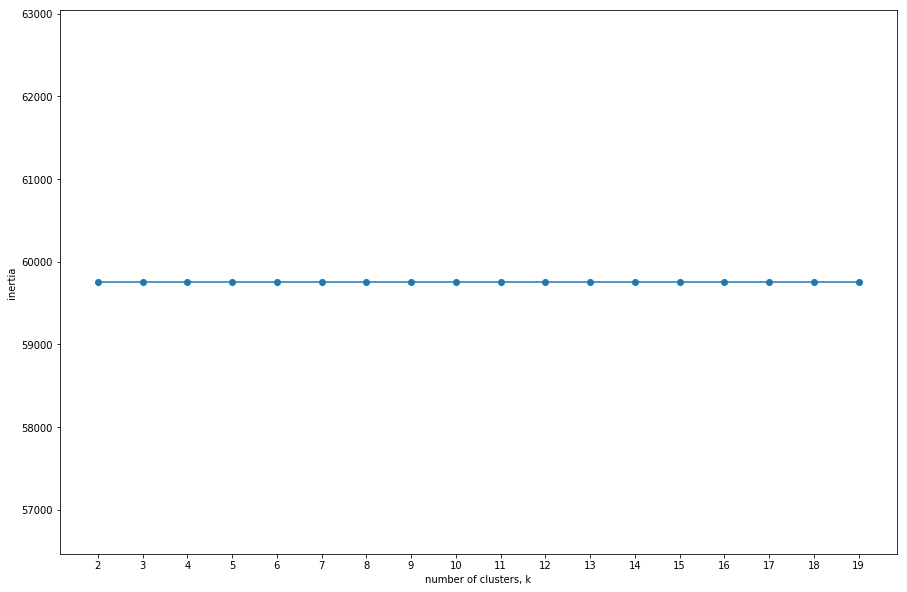

In [44]:
from sklearn.cluster import AgglomerativeClustering

# Create table of values only
x_cols = table.values
ks = range(2, 20)
inertias = []

for k in ks:
    # create a KMeans instance with k clusters
    ward = AgglomerativeClustering(n_clusters = k, linkage='ward')
    # fit model to samples
    ward.fit(x_cols)
    # append the inertia to the list of inertias
    #inertias.append(model.inertia_)

# plot ks vs inertias
plt.figure(figsize=(15,10))
plt.plot(ks, inertias, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

In [ ]:
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering

x_cols = table.values
# create a KMeans instance with k clusters
model = AgglomerativeClustering(n_clusters = 10, linkage = 'ward')
# fit model to samples
model.fit(x_cols)
# append the inertia to the list of inertias
#inertias.append(model.inertia_)
# Create labels for data
labels = model.predict(x_cols)

# create bar chart
clusters, npoints = np.unique(labels, return_counts=True)
plt.bar(clusters, npoints)
plt.xticks(clusters)
plt.ylabel('points')
plt.xlabel('clusters')
plt.show()

In [20]:
labels = pd.DataFrame({'cluster_id': labels})

NameError: name 'labels' is not defined

In [ ]:
table.index.name = 'customer_unique_id'

In [ ]:
table = table.reset_index()

In [ ]:
df = pd.concat([table.customer_unique_id, \
                labels], axis=1, sort=False)

In [ ]:
df = df.replace({"customer_unique_id": index_to_user_mapping})

In [ ]:
df.head()

In [ ]:
item_features_clustered = item_features.merge(df, on = 'customer_unique_id')

In [ ]:
#item_features_clustered.to_csv(r'/Users/mattmerrill/Springboard/Capstone2/olist_datascience/exploration/item_features_clustered.csv')

In [ ]:
item_features_clustered[item_features_clustered['cluster_id'] == 14]['product_category_name'].value_counts()[:20]